In [1]:
!pip install spacy==2.3.5
!pip install scispacy==0.3.0
!pip install eli5

     |████████████████████████████████| 10.4MB 7.4MB/s 
     |████████████████████████████████| 1.1MB 41.8MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 51kB 3.4MB/s 
     |████████████████████████████████| 71kB 4.7MB/s 
     |████████████████████████████████| 13.5MB 309kB/s 
     |████████████████████████████████| 194kB 43.7MB/s 
     |████████████████████████████████| 112kB 7.8MB/s 


In [2]:
import spacy
import scispacy
import eli5

from tqdm import tqdm
from pprint import pprint
from collections import OrderedDict
import pandas as pd

from spacy import displacy
from scispacy.umls_linking import UmlsEntityLinker

from sklearn.base import BaseEstimator
from typing import Dict, Tuple
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier

# Standard Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown


# should be 2.3.5 and >=0.3.0
spacy.__version__, scispacy.__version__

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


('2.3.5', '0.3.0')

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Read in structured data with relevant features (MedNLI and hand labeled data)

In [6]:
# read in hand labeled data
hand_df = pd.read_csv("gdrive/MyDrive/6.871/hand_labeled_mimic_features.csv")

In [7]:
print(hand_df)
print(len(hand_df))

    Unnamed: 0  neg_check_umls  ...  pair_id  contradiction?
0            0               1  ...        0               0
1            1               0  ...        1               0
2            2               0  ...        2               0
3            3               1  ...        3               0
4            4               0  ...        4               0
5            5               0  ...        5               0
6            6               1  ...        6               0
7            7               0  ...        7               0
8            8               0  ...        8               0
9            9               1  ...        9               0
10          10               0  ...       10               0
11          11               1  ...       11               0
12          12               0  ...       12               0
13          13               0  ...       13               1
14          14               0  ...       14               0
15          15          

In [17]:
# split labeled data into training, testing sets for hand labeled data

hand_X = hand_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
hand_y = hand_df["contradiction?"]

hand_train_X, hand_test_X, hand_train_y, hand_test_y = train_test_split(hand_X, hand_y, test_size=0.2)

In [12]:
# split labeled data into training, testing sets for MedNLI data
train_df = pd.read_csv("gdrive/MyDrive/6.871/train_features.csv")
dev_df = pd.read_csv("gdrive/MyDrive/6.871/dev_features.csv")
test_df = pd.read_csv("gdrive/MyDrive/6.871/test_features.csv")

total_train_df = pd.concat((train_df, dev_df), axis=0)
print(total_train_df)

      Unnamed: 0  baseline   cr  ...  vaccines  vaccine  euvolemic
0              0       1.0  1.0  ...       NaN      NaN        NaN
1              1       0.0  1.0  ...       NaN      NaN        NaN
2              0       1.0  1.0  ...       NaN      NaN        NaN
3              1       0.0  1.0  ...       NaN      NaN        NaN
4              0       NaN  NaN  ...       NaN      NaN        NaN
...          ...       ...  ...  ...       ...      ...        ...
1893           1       NaN  NaN  ...       NaN      NaN        NaN
1894           0       NaN  NaN  ...       NaN      NaN        NaN
1895           1       NaN  NaN  ...       NaN      NaN        NaN
1896           0       NaN  NaN  ...       NaN      NaN        NaN
1897           1       NaN  NaN  ...       NaN      NaN        NaN

[16874 rows x 7469 columns]


In [20]:
# fill Na with 0
total_train_df = total_train_df.fillna(0)
test_df = test_df.fillna(0)

# split into training and test sets with relevant features
total_train_X = total_train_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
total_train_y = total_train_df["contradiction?"]

total_test_X = test_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
total_test_y = test_df["contradiction?"]

train_X = pd.concat((total_train_X, hand_train_X), axis=0)
test_X = pd.concat((total_test_X, hand_test_X), axis=0)
train_y = pd.concat((total_train_y, hand_train_y), axis=0)
test_y = pd.concat((total_test_y, hand_test_y), axis=0)

print(train_X)
print(test_X)
print(train_y)
print(test_y)

    check_umls  neg_check_umls  check_med7   dep_sim
0            0               0           0  0.611129
1            0               0           0  0.611129
2            0               0           0  0.564029
3            0               0           0  0.564029
4            0               0           0  0.652266
..         ...             ...         ...       ...
7            0               0           0  0.713808
36           1               0           0  0.629654
24           1               0           1  0.388291
37           1               0           0  0.609080
39           0               1           0  0.705798

[16917 rows x 4 columns]
    check_umls  neg_check_umls  check_med7   dep_sim
0            0               0           0  0.591419
1            0               0           0  0.591419
2            0               0           0  0.595948
3            0               0           0  0.595948
4            0               0           0  0.832968
..         ...      

In [21]:
# RULES:
# check_umls: if they do not share a concept, return 1 (no contradiction)
# neg_check_umls: if number of neg tokens is equal, return 0 (no contradiction); otherwise, return 1 (contradiction)
# check_med7: if not talking about same DRUG -> return 0 (no contradiction); if same DRUG but different other info -> return 1 (contradiction)
# dep_sim: if similarity < 0.5 (contradiction)


rules = {"check_umls": [
                ("=", 1, 0.0)
              ], 
        "neg_check_umls": [
                ("=", 1, 1.0)
              ],
         "check_med7": [
                ("=", 1, 1.0)
              ],
         "dep_sim": [
                ("<", 0.5, 1.0)
              ]
        }

In [22]:
class RuleAugmentedEstimator(BaseEstimator):
  """
  Augments sklearn estimators with deterministic rule-based logic.
  """

  def __init__(self, base_model: BaseEstimator, rules: Dict, **base_params):
      """
      Initializes the rule-augmented estimator by supplying underlying sklearn estimator
      and hard-coded rules.

      Args:
        base_model: underlying sklearn estimator.
          Must implement fit and predict method.
        rules: hard coded rules in format of dictionary,
          with keys being the pandas dataframe column name, 
          and values being a tuple in the following form: 
          (comparison operator, value, return value)

          Acceptable comparison operators are: 
          "=", "<", ">", "<=", ">="

          Example:
                
                {"House Type": [
                    ("=", "Penthouse", 1.0),
                    ("=", "Shack", 0.0)
                  ],
                  "House Price": [
                      ("<", 1000.0, 0.0),
                      (">=", 500000.0, 1.0)
                ]}
        **base_params: Optional keyword arguments which will be passed on
            to the base_model.

      """
      self.rules = rules
      self.base_model = base_model
      self.base_model.set_params(**base_params)
      self.outcome_range = [0,1]

  def __repr__(self):
      return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(self.base_model, self.rules)

  def __str__(self):
      return self.__str__

  def _get_base_model_data(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
      """
      Filters the training data for data points not affected by the rules.
      """
      train_x = X

      for category, rules in self.rules.items():

          if category not in train_x.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  train_x = train_x.loc[train_x[category] != rule[1]]

              elif rule[0] == "<":
                  train_x = train_x.loc[train_x[category] >= rule[1]]

              elif rule[0] == ">":
                  train_x = train_x.loc[train_x[category] <= rule[1]]

              elif rule[0] == "<=":
                  train_x = train_x.loc[train_x[category] > rule[1]]

              elif rule[0] == ">=":
                  train_x = train_x.loc[train_x[category] < rule[1]]

              else:
                  print("Invalid rule detected: {}".format(rule))
              
      indices = train_x.index.values
      train_y = y.iloc[indices]
      
      train_x = train_x.reset_index(drop=True)
      train_y = train_y.reset_index(drop=True)
      
      return train_x, train_y   

  def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
      """Fits the estimator to the data.
      
      Fits the estimator to the data, only training the underlying estimator
      on data which isn't affected by the hard-coded rules.
      
      Args:
          X: The training feature data.
          y: The training label data.
          **kwargs: Optional keyword arguments passed to the underlying
          estimator's fit function.
              
      """
      train_x, train_y = self._get_base_model_data(X, y)
      self.base_model.fit(train_x, train_y, **kwargs)

  def predict(self, X: pd.DataFrame) -> np.array:
      """Gets predictions for the provided feature data.
      
      The predicitons are evaluated using the provided rules wherever possible
      otherwise the underlying estimator is used.
      
      Args:
          X: The feature data to evaluate predictions for.
      
      Returns:
          np.array: Evaluated predictions.
      """
      
      p_X = X.copy()
      p_X['prediction'] = np.nan

      for category, rules in self.rules.items():

          if category not in p_X.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  p_X.loc[p_X[category] == rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<":
                  p_X.loc[p_X[category] < rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">":
                  p_X.loc[p_X[category] > rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<=":
                  p_X.loc[p_X[category] <= rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">=":
                  p_X.loc[p_X[category] >= rule[1], 'prediction'] = rule[2]

              else:
                  print("Invalid rule detected: {}".format(rule))

      if len(p_X.loc[p_X['prediction'].isna()].index != 0):

          base_X = p_X.loc[p_X['prediction'].isna()].copy()
          base_X.drop('prediction', axis=1, inplace=True)
          p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)

      return p_X['prediction'].values
    
  def get_params(self, deep: bool = True) -> Dict:
      """Return the model's and base model's parameters.
      Args:
          deep: Whether to recursively return the base model's parameters.
      Returns
          Dict: The model's parameters.
      """
      
      params = {'base_model': self.base_model,
                'outcome_range': self.outcome_range,
                'rules': self.rules
                }

      params.update(self.base_model.get_params(deep=deep))
      return params
    
  def set_params(self, **params):
      """Sets parameters for the model and base model.
      Args:
          **params: Optional keyword arguments.
      """
                
      parameters = params
      param_keys = parameters.keys()
      
      if 'base_model' in param_keys:
          value = parameters.pop('base_model')
          self.base_model = value

In [23]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [24]:
# fit the hybrid model with relevant features
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
hybrid_model = RuleAugmentedEstimator(gbc, rules)

hybrid_model.fit(train_X, train_y)
predictions = hybrid_model.predict(test_X)

      Iter       Train Loss   Remaining Time 
         1           1.3740            0.85s
         2           1.3716            0.77s
         3           1.3696            0.73s
         4           1.3678            0.72s
         5           1.3662            0.70s
         6           1.3647            0.69s
         7           1.3635            0.67s
         8           1.3620            0.66s
         9           1.3610            0.67s
        10           1.3599            0.66s
        20           1.3503            0.53s
        30           1.3435            0.48s
        40           1.3374            0.41s
        50           1.3316            0.35s
        60           1.3266            0.29s
        70           1.3212            0.21s
        80           1.3163            0.14s
        90           1.3105            0.07s
       100           1.3056            0.00s


Recall:  0.5842105263157895
Accuracy:  0.605138961719979
Precision:  0.6078860898138007
F1:  0.5958132045088567


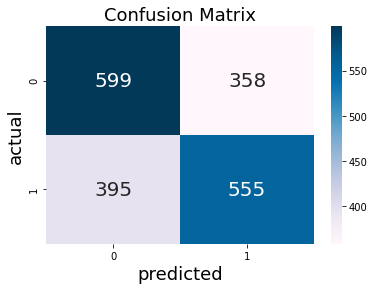

In [25]:
# hybrid (with hand labeled)
evaluation(test_y, predictions)

In [36]:
# hybrid model features
num_feats = list(train_X.columns)
feat_imp = eli5.explain_weights_df(gbc, top=10, feature_names=num_feats)
print(feat_imp)

          feature    weight       std
0  neg_check_umls  0.476461  0.238417
1         dep_sim  0.428110  0.275289
2      check_umls  0.088961  0.052533
3      check_med7  0.006468  0.041916


Rule based model only

In [26]:
class RuleBasedEstimator(BaseEstimator):
  """
  Uses deterministic rule-based logic.
  """

  def __init__(self, base_model: BaseEstimator, rules: Dict, **base_params):
      """
      Initializes the rule-based estimator by supplying hard-coded rules.

      Args:
        base_model: underlying sklearn estimator.
          Must implement fit and predict method.
        rules: hard coded rules in format of dictionary,
          with keys being the pandas dataframe column name, 
          and values being a tuple in the following form: 
          (comparison operator, value, return value)

          Acceptable comparison operators are: 
          "=", "<", ">", "<=", ">="

          Example:
                
                {"House Type": [
                    ("=", "Penthouse", 1.0),
                    ("=", "Shack", 0.0)
                  ],
                  "House Price": [
                      ("<", 1000.0, 0.0),
                      (">=", 500000.0, 1.0)
                ]}
        **base_params: Optional keyword arguments which will be passed on
            to the base_model.

      """
      self.rules = rules
      self.base_model = base_model
      self.base_model.set_params(**base_params)

  def __repr__(self):
      return "Rule Augmented Estimator:\n\n\t Base Model: {}\n\t Rules: {}".format(self.base_model, self.rules)

  def __str__(self):
      return self.__str__
  

  def fit(self, X: pd.DataFrame, y: pd.Series, **kwargs):
      """Fits the estimator to the data.
      
      Fits the estimator to the data, only training the underlying estimator
      on data which isn't affected by the hard-coded rules.
      
      Args:
          X: The training feature data.
          y: The training label data.
          **kwargs: Optional keyword arguments passed to the underlying
          estimator's fit function.
              
      """
      self.base_model.fit(X, y, **kwargs)

  def predict(self, X: pd.DataFrame) -> np.array:
      """Gets predictions for the provided feature data.
      
      The predicitons are evaluated using the provided rules wherever possible
      otherwise the underlying estimator is used.
      
      Args:
          X: The feature data to evaluate predictions for.
      
      Returns:
          np.array: Evaluated predictions.
      """
      
      p_X = X.copy()
      p_X['prediction'] = np.nan

      for category, rules in self.rules.items():

          if category not in p_X.columns.values: continue

          for rule in rules:

              if rule[0] == "=":
                  p_X.loc[p_X[category] == rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<":
                  p_X.loc[p_X[category] < rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">":
                  p_X.loc[p_X[category] > rule[1], 'prediction'] = rule[2]

              elif rule[0] == "<=":
                  p_X.loc[p_X[category] <= rule[1], 'prediction'] = rule[2]

              elif rule[0] == ">=":
                  p_X.loc[p_X[category] >= rule[1], 'prediction'] = rule[2]

              else:
                  print("Invalid rule detected: {}".format(rule))

      # check if any predictions missing (relegate to base_model)
      if len(p_X.loc[p_X['prediction'].isna()].index != 0):

          base_X = p_X.loc[p_X['prediction'].isna()].copy()
          base_X.drop('prediction', axis=1, inplace=True)
          p_X.loc[p_X['prediction'].isna(), 'prediction'] = self.base_model.predict(base_X)

      return p_X['prediction'].values
    

  def get_params(self, deep: bool = True) -> Dict:
      """Return the model's and base model's parameters.
      Args:
          deep: Whether to recursively return the base model's parameters.
      Returns
          Dict: The model's parameters.
      """
      
      params = {'base_model': self.base_model,
                'rules': self.rules
                }

      params.update(self.base_model.get_params(deep=deep))
      return params
  

  def set_params(self, **params):
      """Sets parameters for the model and base model.
      Args:
          **params: Optional keyword arguments.
      """
                
      parameters = params
      param_keys = parameters.keys()
      
      if 'base_model' in param_keys:
          value = parameters.pop('base_model')
          self.base_model = value
          
      if 'rules' in param_keys:
          value = parameters.pop('rules')
          self.rules = value
      
      self.base_model.set_params(**parameters)

In [27]:
# RULES:
# check_umls: if they do not share a concept, return 1 (no contradiction)
# neg_check_umls: if number of neg tokens is equal, return 0 (no contradiction); otherwise, return 1 (contradiction)
# check_med7: if not talking about same DRUG -> return 0 (no contradiction); if same DRUG but different other info -> return 1 (contradiction)
# dep_sim: if similarity < 0.5 (contradiction)


rules = {"check_umls": [
                ("=", 1, 0.0)
              ], 
        "neg_check_umls": [
                ("=", 1, 1.0)
              ],
         "check_med7": [
                ("=", 1, 1.0)
              ],
         "dep_sim": [
                ("<", 0.5, 1.0)
              ]
        }

In [28]:
# fit the hybrid model with relevant features
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
rule_model = RuleBasedEstimator(gbc, rules)

rule_model.fit(train_X, train_y)
predictions = rule_model.predict(test_X)

      Iter       Train Loss   Remaining Time 
         1           1.3757            1.15s
         2           1.3671            1.07s
         3           1.3600            1.05s
         4           1.3542            1.06s
         5           1.3495            1.03s
         6           1.3455            1.01s
         7           1.3423            1.02s
         8           1.3396            0.99s
         9           1.3373            0.97s
        10           1.3354            0.97s
        20           1.3257            0.86s
        30           1.3208            0.79s
        40           1.3158            0.67s
        50           1.3121            0.55s
        60           1.3079            0.44s
        70           1.3049            0.32s
        80           1.3020            0.22s
        90           1.2986            0.11s
       100           1.2956            0.00s


Recall:  0.5610526315789474
Accuracy:  0.5862611431567908
Precision:  0.5889502762430939
F1:  0.5746630727762804


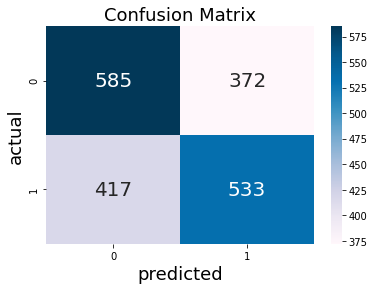

In [29]:
# rule only (with hand labeled)
evaluation(test_y, predictions)

Decision tree algorithm only

In [30]:
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
gbc.fit(train_X, train_y)
predictions = gbc.predict(test_X)

      Iter       Train Loss   Remaining Time 
         1           1.3757            1.30s
         2           1.3671            1.12s
         3           1.3600            1.05s
         4           1.3542            1.01s
         5           1.3495            0.99s
         6           1.3455            0.97s
         7           1.3423            0.95s
         8           1.3396            0.96s
         9           1.3373            0.96s
        10           1.3354            0.94s
        20           1.3257            0.80s
        30           1.3208            0.73s
        40           1.3158            0.63s
        50           1.3121            0.53s
        60           1.3079            0.42s
        70           1.3049            0.32s
        80           1.3020            0.21s
        90           1.2986            0.11s
       100           1.2956            0.00s


Recall:  0.5326315789473685
Accuracy:  0.5951756685894074
Precision:  0.6067146282973621
F1:  0.5672645739910315


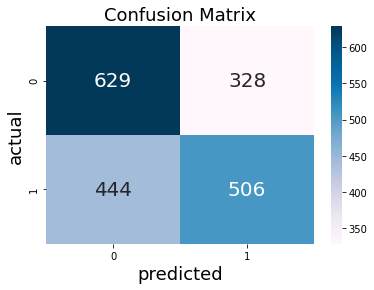

In [31]:
# GBC only (with hand labeled)
evaluation(test_y, predictions)

MIMIC qualitative exploration

In [24]:
# for processed sentence pairs from MIMIC
mimic_df = pd.read_csv("gdrive/MyDrive/6.871/mimic_features.csv")
print(mimic_df)

     Unnamed: 0  neg_check_umls  ...         conflict_type  pair_id
0             0               0  ...         ['diagnosis']        0
1             1               0  ...         ['diagnosis']        1
2             2               0  ...         ['diagnosis']        2
3             3               0  ...         ['diagnosis']        3
4             4               0  ...         ['diagnosis']        4
..          ...             ...  ...                   ...      ...
836         836               0  ...              ['test']      156
837         837               0  ...              ['test']      157
838         838               0  ...  ['diagnosis', 'med']      158
839         839               0  ...  ['diagnosis', 'med']      159
840         840               0  ...  ['diagnosis', 'med']      160

[841 rows x 10 columns]


In [25]:
mimic_X = mimic_df[['check_umls', 'neg_check_umls', "check_med7", "dep_sim"]].copy()
print(mimic_X)

     check_umls  neg_check_umls  check_med7   dep_sim
0             1               0           0  0.761119
1             1               0           0  0.268047
2             1               0           0  0.588540
3             1               0           0  0.758409
4             1               0           0  0.808922
..          ...             ...         ...       ...
836           1               0           0  0.327957
837           1               0           0  0.868670
838           1               0           0  0.643665
839           1               0           0  0.658082
840           1               0           0  0.941207

[841 rows x 4 columns]


In [61]:
# gbc only
gbc = GradientBoostingClassifier(n_estimators=100, verbose=1)
gbc.fit(train_X, train_y)
predictions = gbc.predict(mimic_X)

      Iter       Train Loss   Remaining Time 
         1           1.3758            0.92s
         2           1.3672            0.86s
         3           1.3603            0.85s
         4           1.3544            0.82s
         5           1.3498            0.83s
         6           1.3458            0.82s
         7           1.3426            0.81s
         8           1.3399            0.81s
         9           1.3376            0.80s
        10           1.3357            0.79s
        20           1.3260            0.67s
        30           1.3209            0.60s
        40           1.3164            0.52s
        50           1.3122            0.44s
        60           1.3084            0.35s
        70           1.3058            0.27s
        80           1.3025            0.18s
        90           1.3000            0.09s
       100           1.2975            0.00s


Qualitative evaluation on mimic

In [62]:
print(predictions)

[0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0
 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1
 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0
 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0
 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1
 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 

In [63]:
# get positive prediction indices
print(type(predictions))
positive_indices = np.where(predictions == 1)
print(positive_indices[0])
print(type(positive_indices[0]))

<class 'numpy.ndarray'>
[  6   7  12  13  15  16  17  18  19  32  33  34  35  37  38  43  45  47
  48  50  63  65  66  80  81  82  88  90  92  93  96 104 105 106 107 108
 109 112 115 118 119 120 125 131 132 133 134 138 139 144 145 146 147 148
 149 150 151 152 153 154 156 157 160 162 164 165 166 175 179 180 181 182
 183 184 185 186 188 189 191 192 193 196 213 214 218 220 221 223 225 226
 227 228 231 240 241 244 245 248 249 252 255 256 259 260 262 266 268 276
 283 287 289 290 291 292 298 299 300 302 314 317 318 319 322 323 329 336
 337 338 339 346 349 350 351 357 362 363 364 366 368 374 381 383 384 392
 393 396 402 405 406 408 409 412 415 418 419 431 432 456 457 459 460 464
 466 469 470 480 488 497 505 509 511 514 521 523 525 527 530 534 560 564
 567 571 572 573 576 577 579 586 593 602 605 607 610 611 613 617 619 622
 630 642 649 653 656 657 661 662 664 680 684 687 690 691 692 693 698 703
 704 709 710 711 717 718 725 727 728 730 732 733 735 737 741 744 746 747
 748 749 751 756 757 773 77

In [64]:
positive_examples_df = pd.DataFrame()
for positive_index in tqdm(positive_indices[0]):
  pos_example = mimic_df.iloc[positive_index]
  positive_examples_df = pd.concat((positive_examples_df, pos_example), axis=1)

100%|██████████| 259/259 [00:00<00:00, 855.45it/s]


In [65]:
print(positive_examples_df)

                                                              6    ...                                                836
Unnamed: 0                                                      6  ...                                                836
neg_check_umls                                                  1  ...                                                  0
check_umls                                                      1  ...                                                  1
check_med7                                                      0  ...                                                  0
sentence_1      She denies ever having a urinary tract    infe...  ...     Neuro: Alert and oriented x 3    Labs / Rad...
sentence_2       No recent UTIs or hx of    resistent organisms.'  ...  -- Guaiac negative    -- labs c/w anemia of ch...
dep_sim                                                  0.306616  ...                                           0.327957
hadm_id                 

In [66]:
positive_examples_df_transposed = positive_examples_df.T 
print(positive_examples_df_transposed)
positive_examples_df_transposed.to_csv("positive_examples_mimic_eval_mednli.csv")

    Unnamed: 0 neg_check_umls check_umls  ... hadm_id  conflict_type pair_id
6            6              1          1  ...  162197  ['diagnosis']       6
7            7              1          1  ...  162197  ['diagnosis']       7
12          12              0          1  ...  162197  ['diagnosis']      12
13          13              0          1  ...  162197  ['diagnosis']      13
15          15              1          1  ...  162197  ['diagnosis']      15
..         ...            ...        ...  ...     ...            ...     ...
825        825              0          0  ...  120799             []     145
827        827              0          0  ...  120799             []     147
834        834              1          1  ...  120799       ['test']     154
835        835              1          1  ...  120799       ['test']     155
836        836              0          1  ...  120799       ['test']     156

[259 rows x 10 columns]


Negative examples

In [67]:
# get negative prediction indices
negative_indices = np.where(predictions == 0)

negative_examples_df = pd.DataFrame()
for negative_index in tqdm(negative_indices[0]):
  neg_example = mimic_df.iloc[negative_index]
  negative_examples_df = pd.concat((negative_examples_df, neg_example), axis=1)

negative_examples_df.to_csv("negative_examples_mimic_eval_mednli.csv")

100%|██████████| 582/582 [00:00<00:00, 866.85it/s]


In [68]:
print(negative_examples_df)

                                                              0    ...                                                840
Unnamed: 0                                                      0  ...                                                840
neg_check_umls                                                  0  ...                                                  0
check_umls                                                      1  ...                                                  1
check_med7                                                      0  ...                                                  0
sentence_1      This is a 60 yo female hx of chronic hep C    ...  ...     RR: 23 (16 - 28) insp/min    SpO2: 97%    H...
sentence_2         Assessment: 60 yo female with hx of chronic...  ...     RR: 25 (19 - 28) insp/min    SpO2: 96%    H...
dep_sim                                                  0.761119  ...                                           0.941207
hadm_id                 

In [69]:
negative_examples_df_transposed = negative_examples_df.T
print(negative_examples_df_transposed)
negative_examples_df_transposed.to_csv("negative_examples_mimic_eval_mednli.csv")

    Unnamed: 0 neg_check_umls check_umls  ... hadm_id         conflict_type pair_id
0            0              0          1  ...  162197         ['diagnosis']       0
1            1              0          1  ...  162197         ['diagnosis']       1
2            2              0          1  ...  162197         ['diagnosis']       2
3            3              0          1  ...  162197         ['diagnosis']       3
4            4              0          1  ...  162197         ['diagnosis']       4
..         ...            ...        ...  ...     ...                   ...     ...
833        833              0          1  ...  120799              ['test']     153
837        837              0          1  ...  120799              ['test']     157
838        838              0          1  ...  120799  ['diagnosis', 'med']     158
839        839              0          1  ...  120799  ['diagnosis', 'med']     159
840        840              0          1  ...  120799  ['diagnosis', 'med'] 